In [1]:
import warnings
warnings.filterwarnings("ignore")
import math
import numpy as np # to use numpy arrays instead of lists
import pandas as pd # DataFrame (table)
import matplotlib.pyplot as plt # to plot

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
!pip install keras-tuner # Install keras-tuner
import keras_tuner as kt # Now import keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [5]:
def leeDatos():

    dataSet = pd.read_csv("gdrive/MyDrive/Colab Notebooks/iris.csv", header=0)


    return dataSet

def normalizar(dataSet=0):
    """
    Normalize data
    """
    dataSet = dataSet.dropna()
    dataSet['Iris-setosa'] = 0
    dataSet.iloc[0:49,5] = 1
    dataSet['Iris-versicolor'] = 0
    dataSet.iloc[50:99,6] = 1
    dataSet['Iris-virginica'] = 0
    dataSet.iloc[100:149,7] = 1
    dataSet = dataSet.drop('species', axis=1)
    #dataSet['species'] = dataSet['species'].str.replace('Iris-setosa', '1')

    for i in range(4):
        dataSet.iloc[:,i] = dataSet.iloc[:,i]  / dataSet.iloc[:,i].abs().max()

    return dataSet

# --------------------
# split data
def splitDataSet(dataSet=0, test_size=.2, randSplit=True):
    """
    Split data in train and test sets
    """

    train, test = train_test_split(dataSet, test_size=test_size, shuffle=randSplit)

    return [train, test]

In [6]:
def mlpNN(dataSet=0, dataSet2=0):

    # Neural Networks TF
    input_shape=dataSet.iloc[:,:4].to_numpy().reshape(len(dataSet),4)[0].shape
    dropout_rate = 0.25

    def build_model(hp):
        num_nodes_hl1 = hp.Int('num_nodes_hl1', min_value=32, max_value=128, step=16)
        num_nodes_hl2 = hp.Int('num_nodes_hl2', min_value=16, max_value=64, step=8)
        num_nodes_hl3 = hp.Int('num_nodes_hl3', min_value=8, max_value=32, step=4)
        model = Sequential([
                          Flatten(input_shape=(input_shape), name="in_Layer"),
                          Dense(units=num_nodes_hl1, activation='tanh', name="HL1"),
                          Dropout(dropout_rate),
                          Dense(units=num_nodes_hl2, activation='tanh', name="HL2"),
                          Dropout(dropout_rate),
                          Dense(units=num_nodes_hl3, activation='tanh', name="HL3"),
                          Dropout(dropout_rate),
                          Dense(3, activation='sigmoid', name="out_Layer"),
                          ])

        opt = tf.keras.optimizers.Adam()
        loss_fun = 'binary_crossentropy'  #'categorical_crossentropy'
        acc = 'binary_accuracy' #tf.keras.metrics.CategoricalAccuracy()

        model.compile(
            optimizer=opt,
            loss=loss_fun,
            metrics=[acc]
            )

        return model

    tuner = kt.Hyperband(build_model,
                        objective='binary_accuracy', #'val_categorical_accuracy'
                        max_epochs=12,
                        factor=3,
                        )

    stop_early = EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max', patience = 5) #'val_categorical_accuracy', 'val_loss'

    num_epochs = 30
    validation_split=0.15

    tuner.search(dataSet.iloc[:,:4].to_numpy().reshape(len(dataSet),4),
                dataSet.iloc[:,4:].to_numpy().reshape(len(dataSet),3),
                validation_split=validation_split,
                epochs=num_epochs,
                callbacks=[stop_early],
                verbose=2)

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""The hyperparameter search is complete.
    The best 'num_nodes_hl1' number of nodes for the HL1 is {best_hps.get('num_nodes_hl1')}
    """)

    model = tuner.hypermodel.build(best_hps)

    print(model.summary())
    print("\n")

    history = model.fit(dataSet.iloc[:,:4].to_numpy().reshape(len(dataSet),4),
                        dataSet.iloc[:,4:].to_numpy().reshape(len(dataSet),3),
                        validation_split=validation_split,
                        epochs=num_epochs,
                        batch_size=15,
                        verbose=2)

    fig = plt.figure()
    fig.add_subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Loss vs Epochs")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    fig.add_subplot(122)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title("Accuracy vs Epochs")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

    print(model.evaluate(dataSet.iloc[:,:4].to_numpy().reshape(len(dataSet),4), dataSet.iloc[:,4:].to_numpy().reshape(len(dataSet),3), verbose=2))
    print("\n")

    #### predict train data ######
    trainModel = pd.DataFrame(model.predict(dataSet.iloc[:,:4].to_numpy().reshape(len(dataSet),4)), columns=['Iris-setosa','Iris-versicolor','Iris-virginica'], index=dataSet.index)

    # test data
    testModel = pd.DataFrame(model.predict(dataSet2.iloc[:,:4].to_numpy().reshape(len(dataSet2),4)), columns=['Iris-setosa','Iris-versicolor','Iris-virginica'], index=dataSet2.index)

    return [trainModel.round().astype(int), testModel.round().astype(int)]


In [7]:
datos = leeDatos()
normdatos = normalizar(datos)

print(datos)
print(normdatos)

ts_size = .25
[trainSet, testSet] = splitDataSet(normdatos, test_size=ts_size, randSplit=True)

     sepal_length  sepal_width  petal_length  petal_width         species
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]
     sepal_length  sepal_width  petal_length  petal_width  Iris-setosa  \
0        0.645

Reloading Tuner from ./untitled_project/tuner0.json
The hyperparameter search is complete.
    The best 'num_nodes_hl1' number of nodes for the HL1 is 80
    


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ in_Layer (Flatten)                   │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL1 (Dense)                          │ (None, 80)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL2 (Dense)                          │ (None, 48)                  │           3,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL3 (Dense)                          │ (None, 24)                  │           1,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out_Layer (Dense)                    │ (None, 3)                   │              75 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,539 (21.64 KB)

 Trainable params: 5,539 (21.64 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/30
7/7 - 2s - 263ms/step - binary_accuracy: 0.4596 - loss: 0.7117 - val_binary_accuracy: 0.6667 - val_loss: 0.6796
Epoch 2/30
7/7 - 0s - 12ms/step - binary_accuracy: 0.6491 - loss: 0.6502 - val_binary_accuracy: 0.6667 - val_loss: 0.6280
Epoch 3/30
7/7 - 0s - 12ms/step - binary_accuracy: 0.7123 - loss: 0.6032 - val_binary_accuracy: 0.6667 - val_loss: 0.6128
Epoch 4/30
7/7 - 0s - 15ms/step - binary_accuracy: 0.6947 - loss: 0.5860 - val_binary_accuracy: 0.6667 - val_loss: 0.5973
Epoch 5/30
7/7 - 0s - 8ms/step - binary_accuracy: 0.6561 - loss: 0.5791 - val_binary_accuracy: 0.6667 - val_loss: 0.5865
Epoch 6/30
7/7 - 0s - 19ms/step - binary_accuracy: 0.7088 - loss: 0.5461 - val_binary_accuracy: 0.6667 - val_loss: 0.5301
Epoch 7/30
7/7 - 0s - 9ms/step - binary_accuracy: 0.7614 - loss: 0.5041 - val_binary_accuracy: 0.7451 - val_loss: 0.4999
Epoch 8/30
7/7 - 0s - 11ms/step - binary_accuracy: 0.7474 - loss: 0.4947 - val_binary_accuracy: 0.7255 - val_loss: 0.4680
Epoch 9/30
7/7 - 0

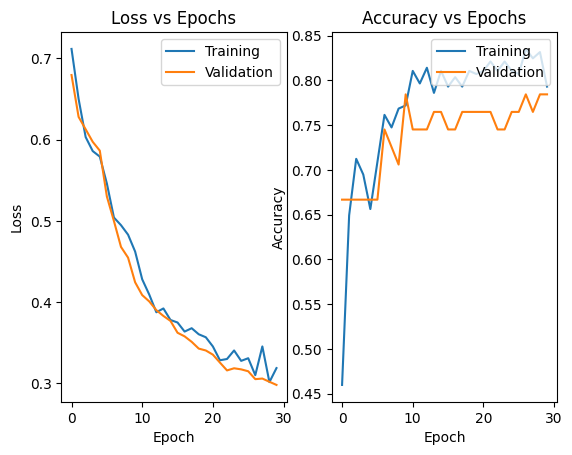

4/4 - 0s - 8ms/step - binary_accuracy: 0.7976 - loss: 0.2818
[0.28184932470321655, 0.7976190447807312]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
     Iris-setosa  Iris-versicolor  Iris-virginica
132            0                0               1
32             1                0               0
1              1                0               0
113            0                0               1
108            0                0               1
42             1                0               0
105            0                0               1
115            0                0               1
79             0                1               0
53             0                1               0
124            0                0               1
82             0                1               0
147            0                0               1
3              1                0               0
52             0                1               0
120            0   

In [8]:
trainModel, testModel = mlpNN(trainSet, testSet)

print(testSet.iloc[:,4:])
print(testModel)

In [15]:
def mlpNN(dataSet=0, dataSet2=0):

    # Neural Networks TF
    input_shape=dataSet.iloc[:,:4].to_numpy().reshape(len(dataSet),4)[0].shape
    dropout_rate = 0.25

    def build_model(hp):

        activ_fun_type = ['relu', 'tanh', 'sigmoid', 'softmax', 'softplus']
        num_nodes_hl1 = hp.Int('num_nodes_hl1', min_value=32, max_value=128, step=16)
        num_nodes_hl2 = hp.Int('num_nodes_hl2', min_value=16, max_value=64, step=8)
        num_nodes_hl3 = hp.Int('num_nodes_hl3', min_value=8, max_value=32, step=4)
        activ_fun_hl1 = hp.Choice('activ_fun_hl1', values=activ_fun_type)
        activ_fun_hl2 = hp.Choice('activ_fun_hl2', values=activ_fun_type)
        activ_fun_hl3 = hp.Choice('activ_fun_hl3', values=activ_fun_type)
        model = Sequential([
                          Flatten(input_shape=(input_shape), name="in_Layer"),
                          Dense(units=num_nodes_hl1, activation=activ_fun_hl1, name="HL1"),
                          Dropout(dropout_rate),
                          Dense(units=num_nodes_hl2, activation=activ_fun_hl2, name="HL2"),
                          Dropout(dropout_rate),
                          Dense(units=num_nodes_hl3, activation=activ_fun_hl2, name="HL3"),
                          Dropout(dropout_rate),
                          Dense(3, activation='sigmoid', name="out_Layer"),
                          ])

        opt = tf.keras.optimizers.Adam()
        loss_fun = 'categorical_crossentropy'  #'categorical_crossentropy'
        acc = 'categorical_accuracy' #tf.keras.metrics.CategoricalAccuracy()

        model.compile(
            optimizer=opt,
            loss=loss_fun,
            metrics=[acc]
            )

        return model

    tuner = kt.Hyperband(build_model,
                        objective='categorical_accuracy', #'categorical_accuracy'
                        max_epochs=12,
                        factor=3,
                        )

    stop_early = EarlyStopping(monitor = 'val_categorical_accuracy', mode = 'max', patience = 5) #'val_categorical_accuracy', 'val_loss'

    num_epochs = 80
    validation_split=0.15

    tuner.search(dataSet.iloc[:,:4].to_numpy().reshape(len(dataSet),4),
                dataSet.iloc[:,4:].to_numpy().reshape(len(dataSet),3),
                validation_split=validation_split,
                epochs=num_epochs,
                callbacks=[stop_early],
                verbose=2)

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""The hyperparameter search is complete.
    The best 'num_nodes_hl1' number of nodes for the HL1 is {best_hps.get('num_nodes_hl1')}
    """)

    model = tuner.hypermodel.build(best_hps)

    print(model.summary())
    print("\n")

    history = model.fit(dataSet.iloc[:,:4].to_numpy().reshape(len(dataSet),4),
                        dataSet.iloc[:,4:].to_numpy().reshape(len(dataSet),3),
                        validation_split=validation_split,
                        epochs=num_epochs,
                        batch_size=15,
                        verbose=2)

    fig = plt.figure()
    fig.add_subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Loss vs Epochs")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    fig.add_subplot(122)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title("Accuracy vs Epochs")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

    print(model.evaluate(dataSet.iloc[:,:4].to_numpy().reshape(len(dataSet),4), dataSet.iloc[:,4:].to_numpy().reshape(len(dataSet),3), verbose=2))
    print("\n")

    #### predict train data ######
    trainModel = pd.DataFrame(model.predict(dataSet.iloc[:,:4].to_numpy().reshape(len(dataSet),4)), columns=['Iris-setosa','Iris-versicolor','Iris-virginica'], index=dataSet.index)

    # test data
    testModel = pd.DataFrame(model.predict(dataSet2.iloc[:,:4].to_numpy().reshape(len(dataSet2),4)), columns=['Iris-setosa','Iris-versicolor','Iris-virginica'], index=dataSet2.index)

    return [trainModel.round().astype(int), testModel.round().astype(int)]


In [7]:
datos = leeDatos()
normdatos = normalizar(datos)

print(datos)
print(normdatos)

ts_size = .25
[trainSet, testSet] = splitDataSet(normdatos, test_size=ts_size, randSplit=True)

     sepal_length  sepal_width  petal_length  petal_width         species
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]
     sepal_length  sepal_width  petal_length  petal_width  Iris-setosa  \
0        0.645

Reloading Tuner from ./untitled_project/tuner0.json
The hyperparameter search is complete.
    The best 'num_nodes_hl1' number of nodes for the HL1 is 96
    


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ in_Layer (Flatten)                   │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL1 (Dense)                          │ (None, 96)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL2 (Dense)                          │ (None, 56)                  │           5,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 56)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL3 (Dense)                          │ (None, 32)                  │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out_Layer (Dense)                    │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,835 (30.61 KB)

 Trainable params: 7,835 (30.61 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/80
7/7 - 7s - 984ms/step - categorical_accuracy: 0.3474 - loss: 1.1138 - val_categorical_accuracy: 0.6471 - val_loss: 0.9948
Epoch 2/80
7/7 - 1s - 92ms/step - categorical_accuracy: 0.4737 - loss: 1.0726 - val_categorical_accuracy: 0.6471 - val_loss: 0.9731
Epoch 3/80
7/7 - 0s - 26ms/step - categorical_accuracy: 0.5368 - loss: 1.0280 - val_categorical_accuracy: 0.6471 - val_loss: 0.9464
Epoch 4/80
7/7 - 0s - 36ms/step - categorical_accuracy: 0.6211 - loss: 0.9832 - val_categorical_accuracy: 0.6471 - val_loss: 0.8950
Epoch 5/80
7/7 - 0s - 41ms/step - categorical_accuracy: 0.6000 - loss: 0.9682 - val_categorical_accuracy: 0.6471 - val_loss: 0.8402
Epoch 6/80
7/7 - 0s - 34ms/step - categorical_accuracy: 0.6526 - loss: 0.9171 - val_categorical_accuracy: 0.6471 - val_loss: 0.7830
Epoch 7/80
7/7 - 0s - 9ms/step - categorical_accuracy: 0.7053 - loss: 0.8205 - val_categorical_accuracy: 0.6471 - val_loss: 0.7150
Epoch 8/80
7/7 - 0s - 20ms/step - categorical_accuracy: 0.7158 - loss

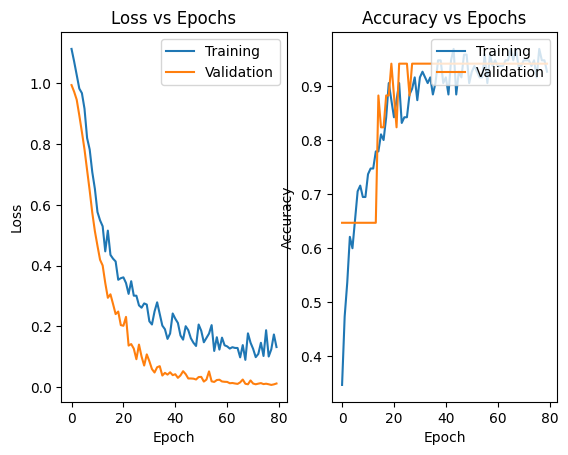

4/4 - 0s - 9ms/step - categorical_accuracy: 0.9554 - loss: 0.0759


[0.07594166696071625, 0.9553571343421936]


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
     Iris-setosa  Iris-versicolor  Iris-virginica
66             0                1               0
70             0                1               0
43             1                0               0
79             0                1               0
73             0                1               0
132            0                0               1
27             1                0               0
78             0                1               0
35             1                0               0
146            0                0               1
136            0                0               1
17             1                0               0
96             0                1               0
124            0                0               1
91             0                1               0
76             0                1               0
58             0                1               0
33             1        

In [16]:
trainModel, testModel = mlpNN(trainSet, testSet)

print(testSet.iloc[:,4:])
print(testModel)

In [17]:
accuracy_score(testSet.iloc[:,4:], testModel)

0.5526315789473685

In [14]:
accuracy_score(testSet.iloc[:,4:], testModel)

0.3684210526315789